In [110]:
# ─── constants ────────────────────────────────────────────────────────────────
TRAIN_FEATS_NONLIN = '../../data/expanded_with_features_non-linear.csv'
TRAIN_FEATS_ALL    = '../../data/expanded_train_all_feats.csv'
TRAIN_META_PATH    = '../../data/train.csv'

TEST_FEATS_NONLIN  = '../../data/normalized_expanded_test.csv'
TEST_FEATS_ALL     = '../../data/expanded_test_all_feats.csv'
TEST_META_PATH     = '../../data/test.csv'
LABELED_TEST_PATH  = '../../data/labeled_test.csv'

# your existing non-linear FEATURES
NL_FEATURES = [
    'degree','closeness','harmonic','betweeness','load','pagerank',
    'eigenvector','katz','information','current_flow_betweeness',
    'percolation','second_order','laplacian',
    'is_leaf','pos_norm','max_branch_size','subtree_entropy'
]

# your existing “all‐feats” FEATURES
ALL_FEATURES = [
    'degree_centrality','closeness_centrality','current_flow_closeness',
    'harmonic_centrality','betweenness_centrality','communicability_betweenness',
    'current_flow_betweenness','load_centrality','pagerank',
    'eigenvector_centrality','katz_centrality','information_centrality',
    'subgraph_centrality','percolation_centrality','second_order_centrality',
    'laplacian_centrality','clustering_coefficient','square_clustering',
    'triangles','core_number','eccentricity'
]

# now combine them into one big feature list
FEATURES = NL_FEATURES + ALL_FEATURES

In [111]:
import pandas as pd, numpy as np, ast
from time import time
from datetime import timedelta
from sklearn.preprocessing    import StandardScaler
from sklearn.model_selection  import GroupShuffleSplit
from itertools                import product
from tqdm                     import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt

import warnings
from sklearn.exceptions import FitFailedWarning

warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [112]:
param_grid = {
    'max_depth':        [4, 6, 8],
    'eta':               [0.01, 0.05, 0.1],
    'subsample':        [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'gamma':            [0, 1],
}

In [113]:
# Custom root‐accuracy scoring (1 root per sentence)
def root_score(sent_ids, y_true, probs):
    dfp = pd.DataFrame({'sent': sent_ids, 'y': y_true, 'p': probs})
    picks = dfp.loc[dfp.groupby('sent')['p'].idxmax()]
    return (picks.y == 1).mean()

In [114]:
print("Loading training data…")
exp   = pd.read_csv(TRAIN_FEATS_PATH)
meta  = pd.read_csv(TRAIN_META_PATH)
meta['edgelist'] = meta['edgelist'].apply(ast.literal_eval)

df = exp.merge(
    meta[['language','sentence','edgelist','root']],
    on=['language','sentence']
)

Loading training data…


In [ ]:
models = {}
t0 = time()
print("→ Tuning per‐language XGB on GPU with early stopping\n")

for lang in tqdm(sorted(df.language.unique())):
    sub = df[df.language == lang].reset_index(drop=True)

    # 80/20 sentence‐wise split
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, val_idx = next(
        gss.split(sub, sub.root, groups=sub.sentence)
    )
    train, val = sub.iloc[tr_idx], sub.iloc[val_idx]

    # feature‐scaling
    scaler = StandardScaler().fit(train[FEATURES])
    X_tr = scaler.transform(train[FEATURES])
    y_tr = (train.root == train.vertex).astype(int)
    X_val = scaler.transform(val[FEATURES])
    y_val = (val.root == val.vertex).astype(int)

    # DMatrix + class‐imbalance
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval   = xgb.DMatrix(X_val, label=y_val)
    neg, pos = len(y_tr)-y_tr.sum(), y_tr.sum()
    spw = neg/pos if pos>0 else 1.0

    best_sc, best_cfg, best_bst = -1, None, None

    # grid‐search
    for md, eta, subs, colsm, gm in product(
        param_grid['max_depth'],
        param_grid['eta'],
        param_grid['subsample'],
        param_grid['colsample_bytree'],
        param_grid['gamma']
    ):
        cfg = {
            'objective':        'binary:logistic',
            'eval_metric':      'error',
            'tree_method':      'hist',
            'device':           'cuda',
            'max_depth':        md,
            'eta':              eta,
            'subsample':        subs,
            'colsample_bytree': colsm,
            'gamma':            gm,
            'scale_pos_weight': spw,
            'seed':             42,
            'verbosity':        0,
        }
        bst = xgb.train(
            cfg,
            dtrain,
            num_boost_round=1000,
            evals=[(dtrain,'train'),(dval,'val')],
            early_stopping_rounds=20,
            verbose_eval=False
        )
        p_val = bst.predict(dval)
        sc    = root_score(val.sentence.values, y_val, p_val)

        if sc > best_sc:
            best_sc, best_cfg, best_bst = sc, cfg, bst

    print(f"{lang:12s} → val-root-acc={best_sc:.3f}  cfg={best_cfg}")
    models[lang] = (scaler, best_bst)

print(f"\n⏱  Done per‐lang tuning in {timedelta(seconds=time()-t0)}\n")

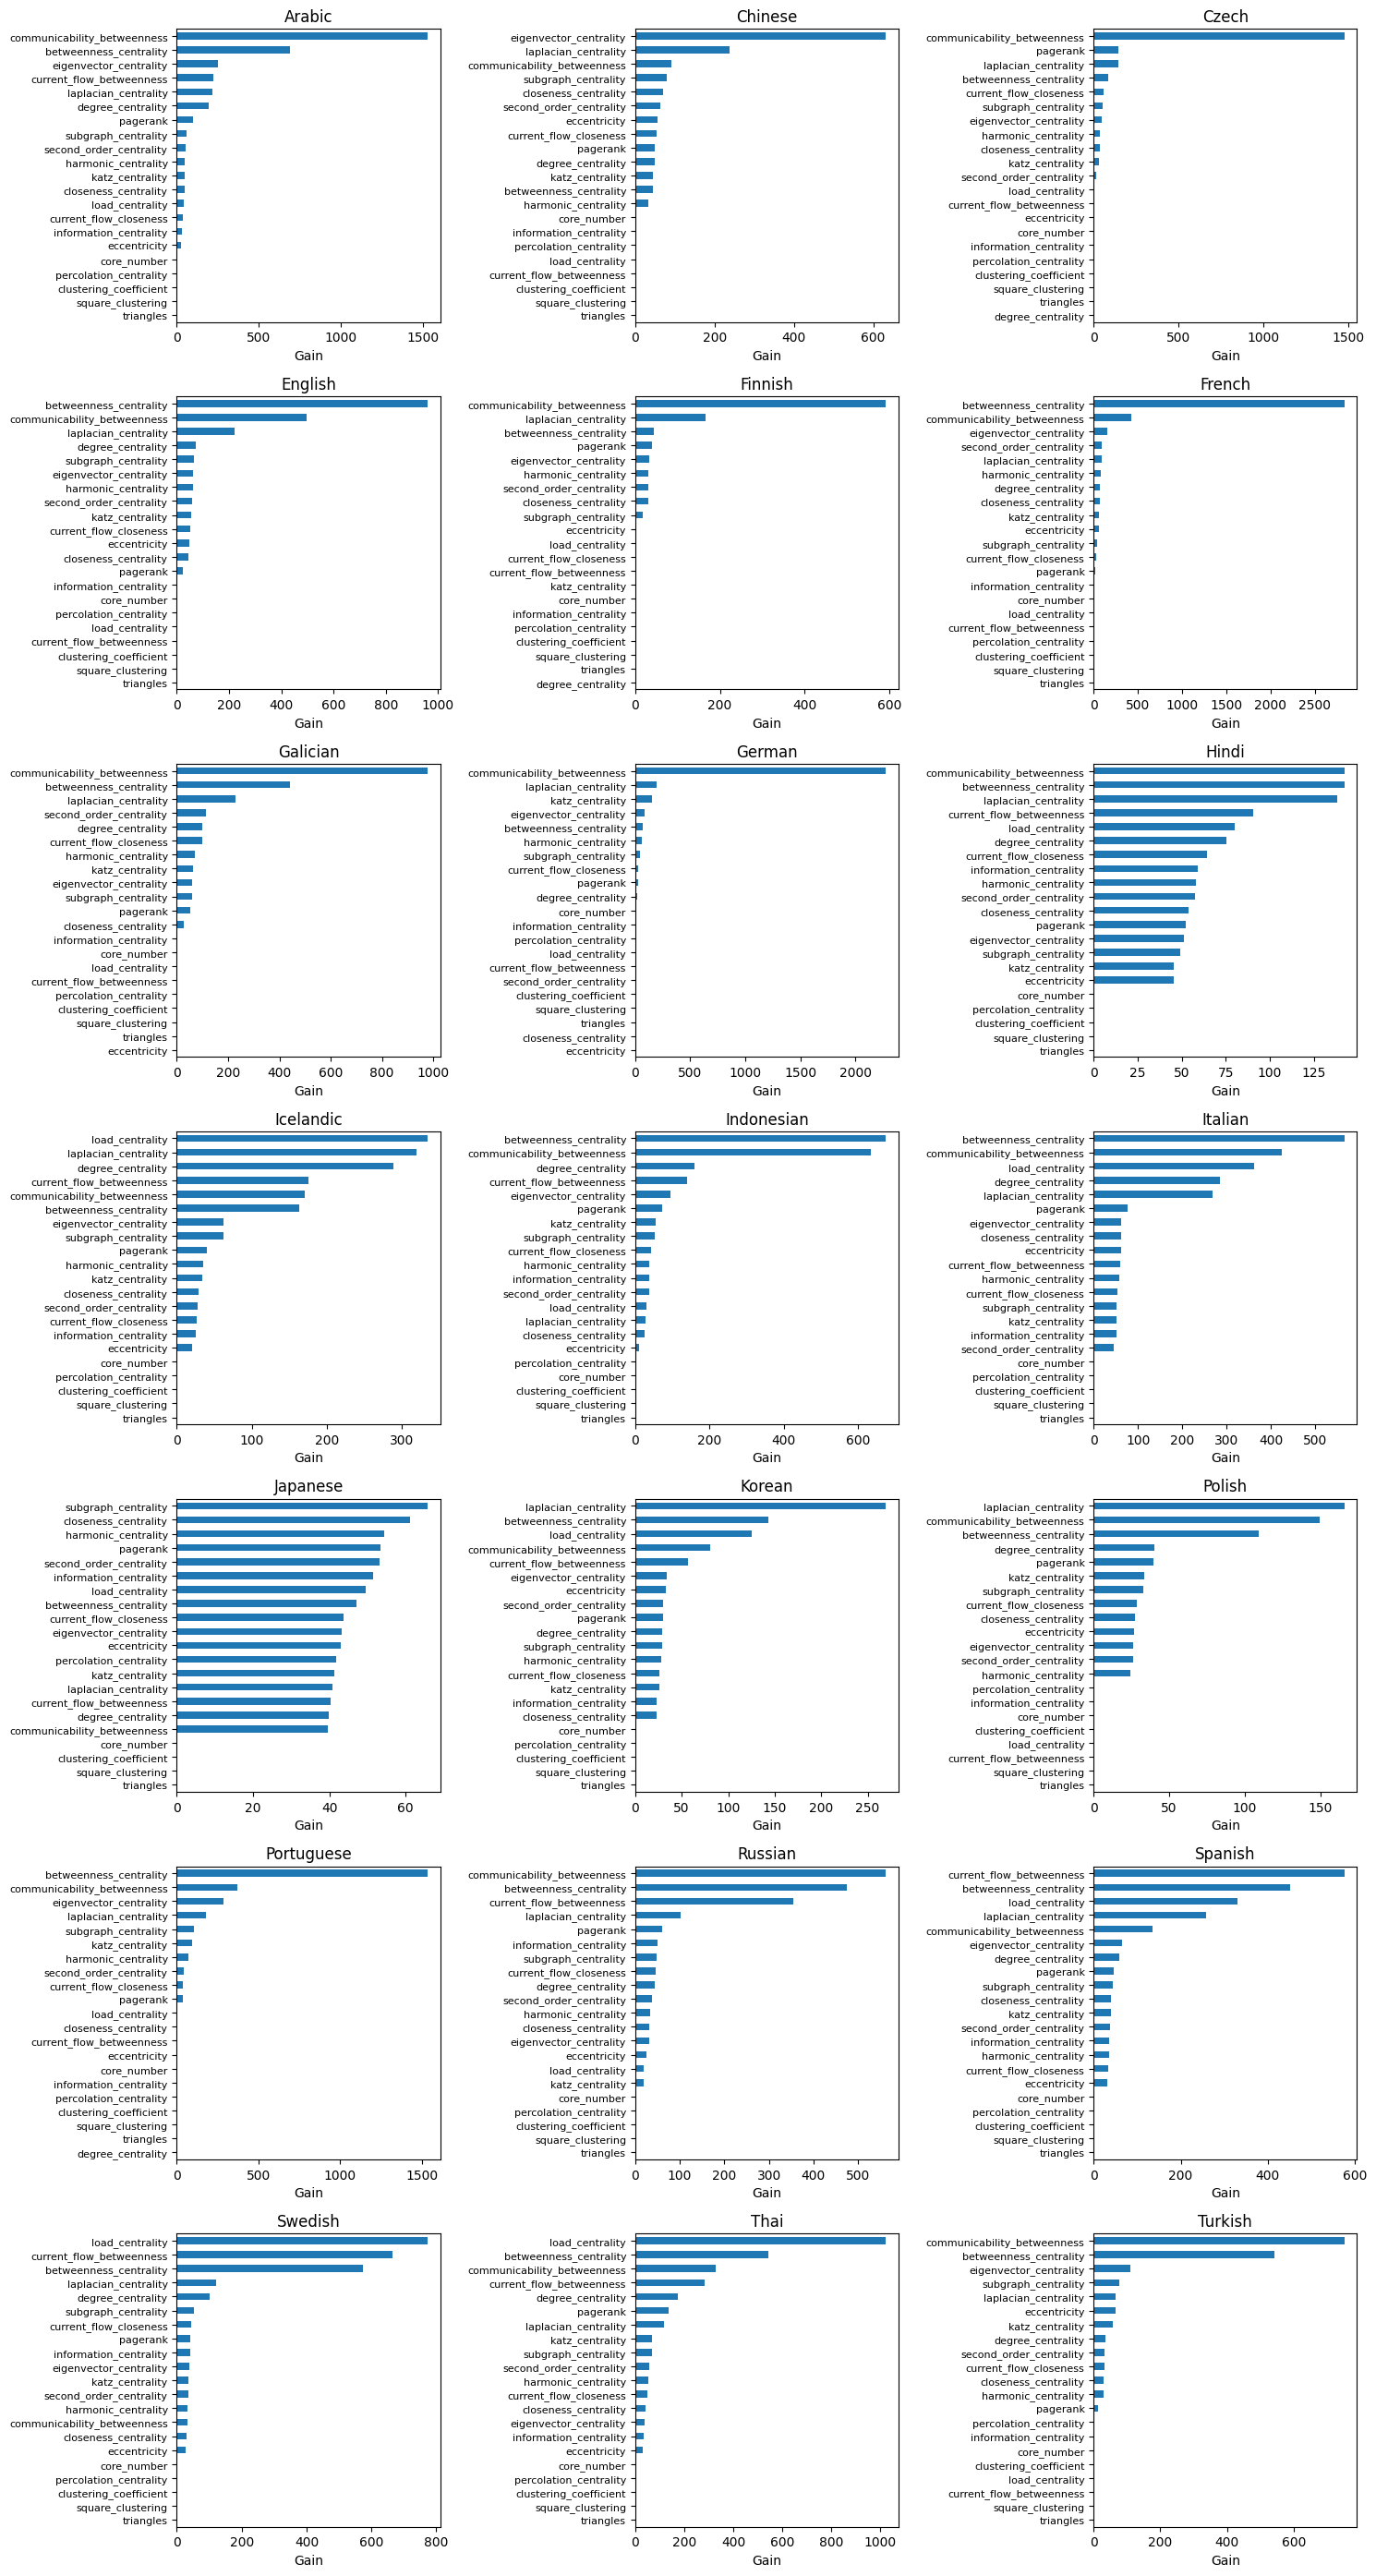

In [66]:
langs = sorted(models.keys())

fig, axes = plt.subplots(7, 3, figsize=(15, 28), sharex=False)
axes = axes.flatten()

for ax, lang in zip(axes, langs):
    scaler, bst = models[lang]
    # raw XGBoost importances are keyed 'f0','f1',...
    raw_imp = bst.get_score(importance_type='gain')
    # map 'f#' → real FEATURES[#]
    imp_mapped = { FEATURES[int(fname[1:])]: gain
                   for fname, gain in raw_imp.items() }
    imp_ser = pd.Series(imp_mapped).reindex(FEATURES).fillna(0)
    
    # plot
    imp_ser.sort_values().plot.barh(
        ax=ax,
        title=lang,
        linewidth=0
    )
    ax.set_xlabel("Gain")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

plt.tight_layout()
plt.show()

In [72]:
print("→ Tuning single global XGB on GPU with early stopping…")

# prepare flat df
df_flat = df.copy()
df_flat['is_root']   = (df_flat.vertex == df_flat.root).astype(int)
df_flat['lang_sent'] = df_flat.language + "_" + df_flat.sentence.astype(str)

# 80/20 split (lang,sentence)-wise
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
tr_idx, val_idx = next(
    gss.split(df_flat, df_flat.is_root, groups=df_flat.lang_sent)
)
train_g, val_g = df_flat.iloc[tr_idx], df_flat.iloc[val_idx]

# scale features
scaler_g = StandardScaler().fit(train_g[FEATURES])
X_trg  = scaler_g.transform(train_g[FEATURES]);  y_trg  = train_g.is_root
X_valg = scaler_g.transform(val_g[FEATURES]);    y_valg = val_g.is_root

# DMatrix + imbalance
dtrain_g = xgb.DMatrix(X_trg,  label=y_trg)
dval_g   = xgb.DMatrix(X_valg, label=y_valg)
neg_g, pos_g = len(y_trg)-y_trg.sum(), y_trg.sum()
spw_g = (neg_g/pos_g) if pos_g>0 else 1.0

best_sc_g, best_cfg_g, best_bst_g = -1, None, None

# grid‐search exactly the same grid you used per‐lang
for md, eta, subs, colsm, gm in product(
        param_grid['max_depth'],
        param_grid['eta'],
        param_grid['subsample'],
        param_grid['colsample_bytree'],
        param_grid['gamma']
):
    cfg = {
        'objective':        'binary:logistic',
        'eval_metric':      'error',
        'tree_method':      'hist',
        'device':           'cuda',
        'max_depth':        md,
        'eta':              eta,
        'subsample':        subs,
        'colsample_bytree': colsm,
        'gamma':            gm,
        'scale_pos_weight': spw_g,
        'seed':             42,
        'verbosity':        0,
    }
    bst = xgb.train(
      cfg,
      dtrain_g,
      num_boost_round=1000,
      evals=[(dtrain_g,'train'),(dval_g,'val')],
      early_stopping_rounds=20,
      verbose_eval=False
    )

    p_valg = bst.predict(dval_g)
    sc_g   = root_score(val_g.sentence.values, y_valg, p_valg)

    if sc_g > best_sc_g:
        best_sc_g, best_cfg_g, best_bst_g = sc_g, cfg, bst

print(f"\n→ GLOBAL best val-root-acc={best_sc_g:.3f} with cfg={best_cfg_g}\n")

# overwrite our previous fixed‐cfg global model
bst_g = best_bst_g

→ Tuning single global XGB on GPU with early stopping…

→ GLOBAL best val-root-acc=0.374 with cfg={'objective': 'binary:logistic', 'eval_metric': 'error', 'tree_method': 'hist', 'device': 'cuda', 'max_depth': 8, 'eta': 0.05, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0, 'scale_pos_weight': 17.849047619047617, 'seed': 42, 'verbosity': 0}



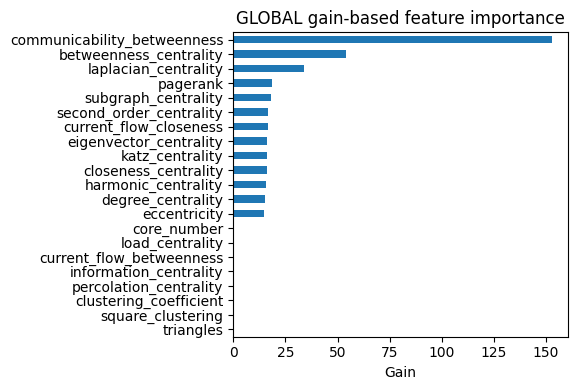

In [73]:
# global feature importance
imp = bst_g.get_score(importance_type='gain')
imp_mapped = { FEATURES[int(f[1:])]: gain for f,gain in imp.items() }
imp_ser_g   = pd.Series(imp_mapped).reindex(FEATURES).fillna(0)

imp_ser_g.sort_values().plot.barh(
    figsize=(6,4),
    title="GLOBAL gain‐based feature importance"
)
plt.xlabel("Gain")
plt.tight_layout()
plt.show()

In [101]:
test_feats = pd.read_csv(TEST_FEATS_PATH)
raw_test   = pd.read_csv(TEST_META_PATH)
raw_test['edgelist'] = raw_test['edgelist'].apply(ast.literal_eval)

# merge in the id→language,sentence
td = test_feats.merge(
    raw_test[['language','sentence','id']],
    on=['language','sentence', 'id'],
    how='left'
)

In [102]:
# per‐language preds
out_lang = []
for tid, grp in td.groupby('id', sort=False):
    scaler, bst = models[grp.language.iloc[0]]
    Xs    = scaler.transform(grp[FEATURES].values)
    dm    = xgb.DMatrix(Xs, feature_names=FEATURES)
    preds = bst.predict(dm)
    root  = int(grp.vertex.values[preds.argmax()])
    out_lang.append({'id': tid, 'root_pred_lang': root})
sub_lang = pd.DataFrame(out_lang)

In [103]:
# global preds
out_glob = []
for tid, grp in td.groupby('id', sort=False):
    Xs    = scaler_g.transform(grp[FEATURES].values)
    dm    = xgb.DMatrix(Xs, feature_names=FEATURES)
    preds = bst_g.predict(dm)
    root  = int(grp.vertex.values[preds.argmax()])
    out_glob.append({'id': tid, 'root_pred_glob': root})
sub_glob = pd.DataFrame(out_glob)

In [104]:
# combine & compare
truth = pd.read_csv(LABELED_TEST_PATH)   # columns: id,root
cmp_l = sub_lang.merge(truth, on='id')
cmp_l['correct_lang'] = cmp_l['root_pred_lang'] == cmp_l['root']
acc_l = cmp_l['correct_lang'].mean()

cmp_g = sub_glob.merge(truth, on='id')
cmp_g['correct_glob'] = cmp_g['root_pred_glob'] == cmp_g['root']
acc_g = cmp_g['correct_glob'].mean()

print(f"→ FINAL per-lang test accuracy: {acc_l:.3%} ({cmp_l.correct_lang.sum()}/{len(cmp_l)})")
print(f"→ FINAL global-XGB test accuracy: {acc_g:.3%} ({cmp_g.correct_glob.sum()}/{len(cmp_g)})")

→ FINAL per-lang test accuracy: 31.573% (3282/10395)
→ FINAL global-XGB test accuracy: 28.485% (2961/10395)
